# Transformer Model used on Time Series to predict Stock Market Data

Ghruank Kothare

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2023-12-31")
close_prices = data['Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [4]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [5]:
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

In [6]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [15]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)
  

In [16]:
input_shape = X_train.shape[1:]
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128, 64],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [17]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [19]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0013 - mae: 0.0258 - val_loss: 0.0016 - val_mae: 0.0334
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 8.8406e-04 - mae: 0.0200 - val_loss: 0.0128 - val_mae: 0.1057
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 7.4242e-04 - mae: 0.0189 - val_loss: 0.0099 - val_mae: 0.0918
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 5.7041e-04 - mae: 0.0165 - val_loss: 0.0038 - val_mae: 0.0555
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 5.6287e-04 - mae: 0.0165 - val_loss: 0.0041 - val_mae: 0.0570
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 5.6302e-04 - mae: 0.0169 - val_loss: 0.0077 - val_mae: 0.0802
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 4.5515e-04 - mae: 0.0150 - val_loss: 0.0031 - val_mae: 0.0489
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 4.9911e-04 - mae: 0.0153 - val_loss: 0.0043 - val_mae: 0.0586
Epoch 9/50
78/78 ━━━━━━━━━━━━━━

In [20]:
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [21]:
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_train_actual = scaler.inverse_transform(y_train).flatten()
y_test_actual = scaler.inverse_transform(y_test).flatten()

In [22]:
prediction_std = np.std(y_test_actual - test_predictions)
lower_bound = test_predictions - 1.96 * prediction_std
upper_bound = test_predictions + 1.96 * prediction_std

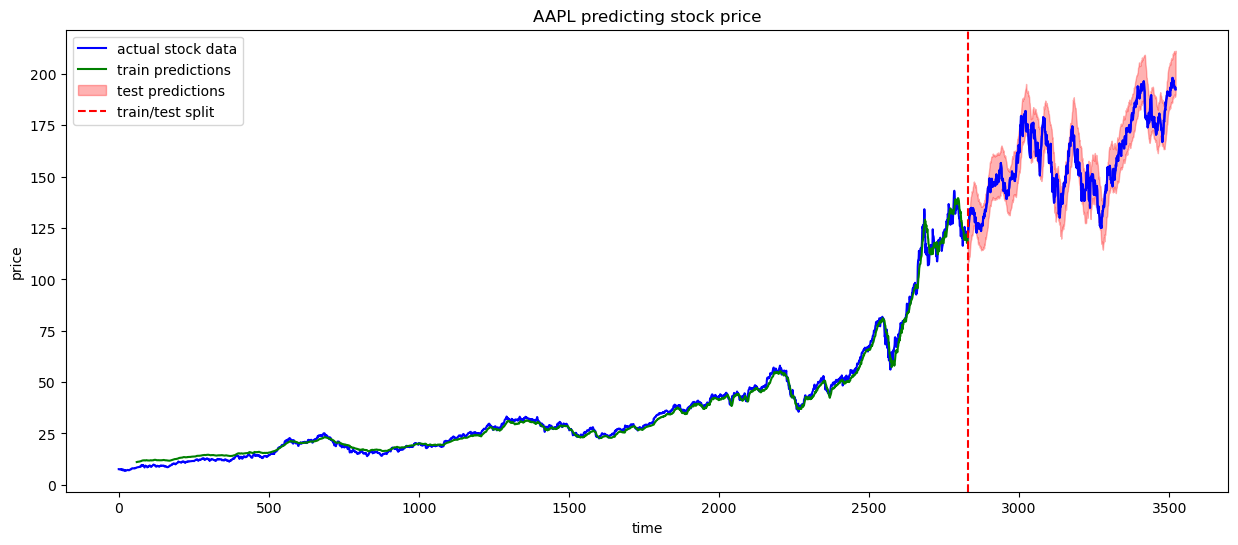

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(close_prices, label='actual stock data', color='blue')

split_point = train_size + sequence_length
plt.plot(range(sequence_length, split_point), train_predictions, label='train predictions', color='green')
plt.fill_between(range(split_point, len(close_prices)), 
                 lower_bound, 
                 upper_bound, 
                 color='red', 
                 alpha=0.3, 
                 label='test predictions')
plt.plot(range(split_point, len(close_prices)), y_test_actual, color='blue')
plt.axvline(x=split_point, color='r', linestyle='--', label='train/test split')
plt.title(f'{ticker} predicting stock price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
train_mse = mean_squared_error(y_train_actual, train_predictions)
test_mse = mean_squared_error(y_test_actual, test_predictions)
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)

In [32]:
print(f"train MSE: {train_mse:.2f}")
print(f"test MSE: {test_mse:.2f}")
print(f"train MAE: {train_mae:.2f}")
print(f"test MAE: {test_mae:.2f}")

train MSE: 4.99
test MSE: 30.44
train MAE: 1.67
test MAE: 4.40
